[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmehrotra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dmehrotra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/dmehrotra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


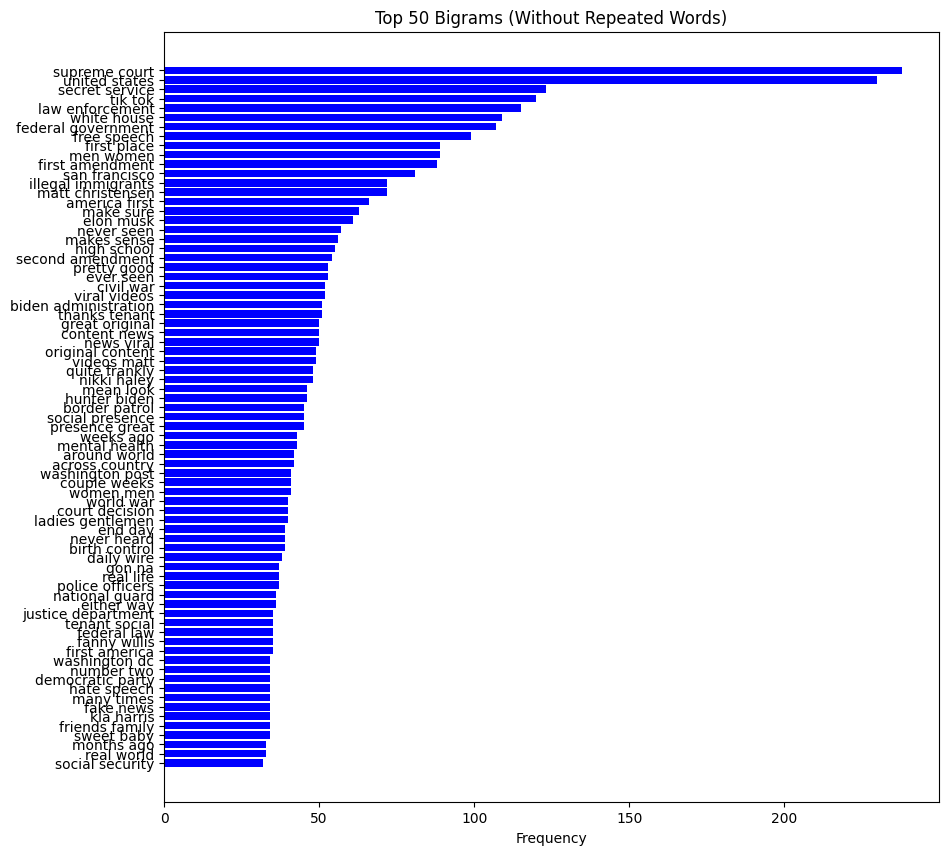

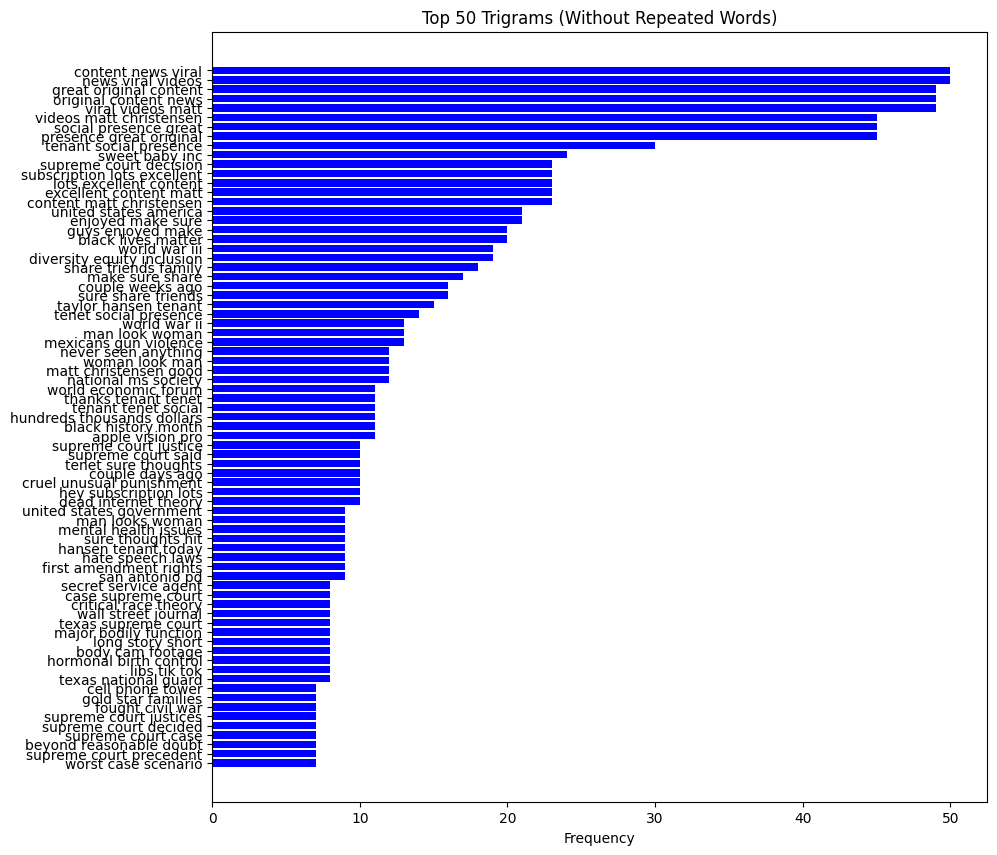

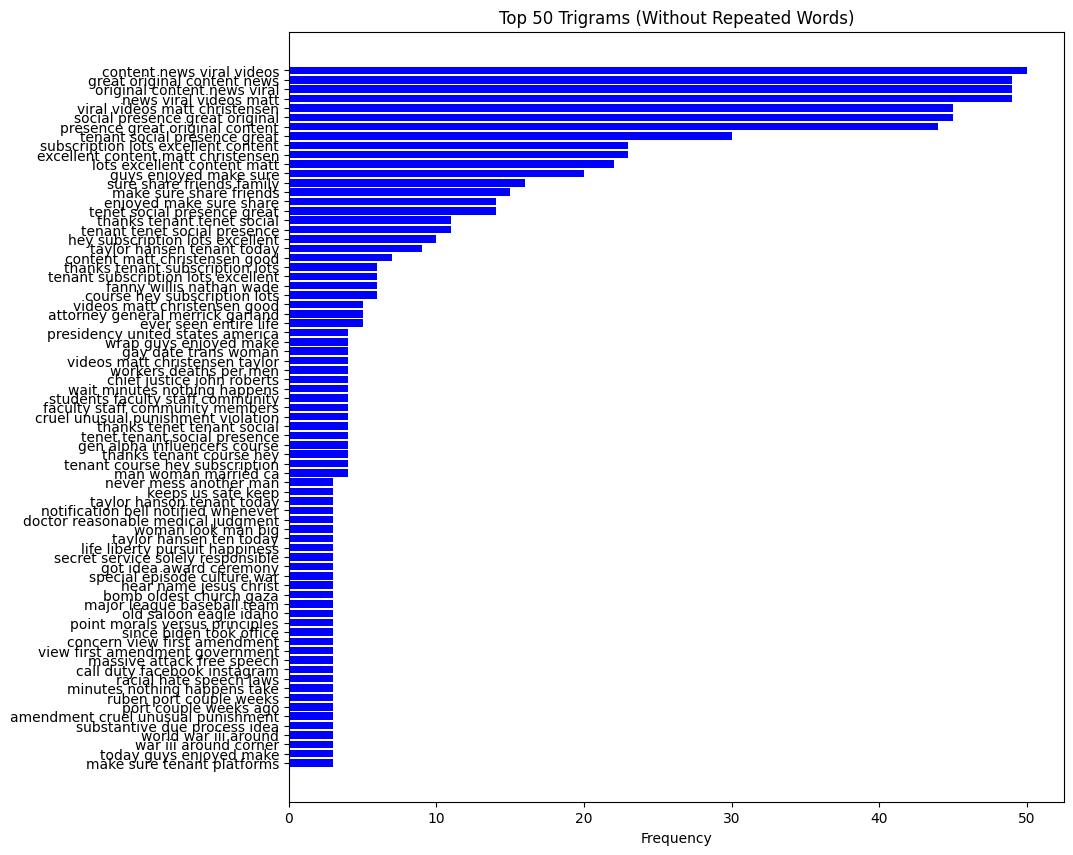

In [131]:

# Get English stopwords from nltk
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
import spacy

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Add custom stopwords
custom_stopwords = {
    'video', "want", "streams", "listening", "listen", "subscribe", "supporting", "next", "time", "every", "single", "president", "wednesday", "sunday", "joe", "state", "donald",
    'youtube', 'watch', 'channel', "yeah", "like", "know", "even", "though", "always", "going","thoughtful","media","thing","else","last","week","things","much",
    'um', 'yeah', 'like', 'uh',"lot","kind", "oh", "let", "live", "stream", "make sure", "think","would","music","applause","comment","yes","right","welcome","back","really","could","okay","well","years","york","new","people","need","little","bit","appreciate","discussion","forward","nights","one"
}
stop_words = set(stopwords.words('english')).union(custom_stopwords)

def tokenize_and_filter(text, min_word_length=1):
    words = word_tokenize(text.lower())  
    pos_tags = pos_tag(words)  

  
    filtered_words = [
        word for word, pos in pos_tags
        if len(word) >= min_word_length and word.isalpha() and word not in stop_words and pos not in ('VB', 'VBG')
    ]
    
    return filtered_words

def filter_repeated_word_ngrams(ngrams):
    return [ngram for ngram in ngrams if len(set(ngram)) == len(ngram)]

def get_ngram_counts(text, n=2, top_n=10):
    tokens = tokenize_and_filter(text)
    n_grams = ngrams(tokens, n)  # Generate n-grams

    # Filter out n-grams where any word is repeated
    filtered_ngrams = filter_repeated_word_ngrams(n_grams)

    # Count the n-grams
    ngram_freq = Counter(filtered_ngrams)  # Count the n-grams
    return ngram_freq.most_common(top_n)  # Return the top n most common n-grams

def plot_ngram_counts(ngram_counts, title='N-Gram Frequency'):
    ngrams, counts = zip(*ngram_counts)
    ngrams = [' '.join(ngram) for ngram in ngrams]  # Convert tuples to strings
    plt.figure(figsize=(10, 10))
    plt.barh(ngrams, counts, color='blue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest counts at the top
    plt.show()

# Assuming 'df' is the DataFrame containing transcripts
df = pd.read_csv('./youtube_video_data.csv')
all_text = " ".join(df['Transcript'])

bigrams = get_ngram_counts(all_text, n=2, top_n=75)
trigrams = get_ngram_counts(all_text, n=3, top_n=75)
quadgrams = get_ngram_counts(all_text, n=4, top_n=75)


# Plot the top bigrams and trigrams
plot_ngram_counts(bigrams, title='Top 50 Bigrams (Without Repeated Words)')
plot_ngram_counts(trigrams, title='Top 50 Trigrams (Without Repeated Words)')
plot_ngram_counts(quadgrams, title='Top 50 Trigrams (Without Repeated Words)')

/Users/dmehrotra/.pyenv/versions/scraping/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make', 'sure'] not in stop_words.
  warnings.warn(


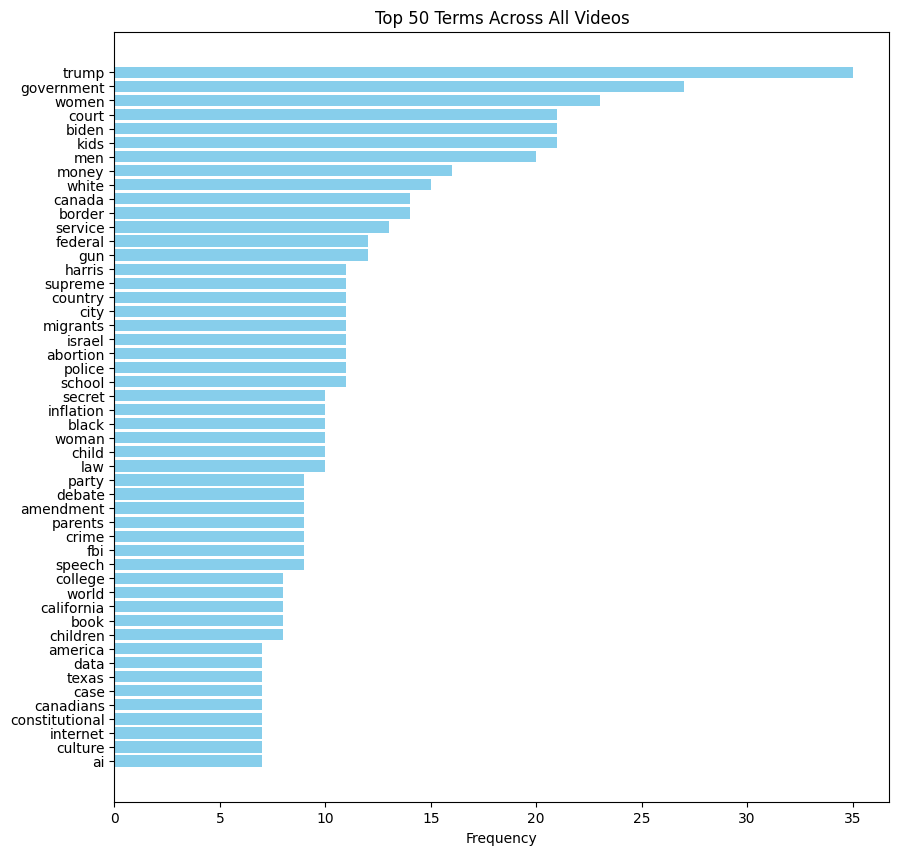

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define custom stopwords
stop_words = list(set(stopwords.words('english')).union(custom_stopwords))

# Function to filter out verbs (including 'ing' forms) from tokens
def filter_verbs(text):
    words = word_tokenize(text.lower())  # Tokenize the text
    pos_tags = pos_tag(words)  # Get the part-of-speech tags
    filtered_words = [word for word, pos in pos_tags if pos not in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ') and word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

# Function to extract top keywords using TF-IDF after filtering out verbs
def extract_keywords(texts, top_n=10):
    # Filter verbs and prepare text
    filtered_texts = [filter_verbs(text) for text in texts]

    # Initialize the TF-IDF vectorizer with the combined stopwords list
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=stop_words)
    tfidf_matrix = vectorizer.fit_transform(filtered_texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Get top terms per document
    top_terms_per_document = []
    for doc_idx, doc in enumerate(tfidf_matrix):
        sorted_items = doc.toarray().argsort()
        top_n_indices = sorted_items[0, -top_n:]  # Get the indices of the top n terms
        top_terms = [feature_names[idx] for idx in top_n_indices]  # Get the terms for those indices
        top_terms_per_document.append(top_terms)
    
    return top_terms_per_document

# Assuming 'df' is the DataFrame containing the transcripts, YouTube URLs, and titles
# Extracting top terms for each video
texts = df['Transcript'].tolist()
top_terms_per_document = extract_keywords(texts, top_n=10)

# Create a DataFrame with YouTube URL, Title, and Top Terms
df['Top Terms'] = top_terms_per_document

# Display the DataFrame with URL, Title, and Top Terms

# Function to generate a bar graph of the top terms across all documents
def plot_top_terms(df, top_n=10):
    all_terms = [term for sublist in df['Top Terms'] for term in sublist]  # Flatten list of all top terms
    term_counts = Counter(all_terms)  # Count occurrences of each term
    
    # Get the most common terms
    common_terms = term_counts.most_common(top_n)
    
    # Plot the bar graph
    terms, counts = zip(*common_terms)
    plt.figure(figsize=(10, 10))
    plt.barh(terms, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top {top_n} Terms Across All Videos')
    plt.gca().invert_yaxis()  # Highest count at the top
    plt.show()

# Plot the top 10 terms across all videos
plot_top_terms(df, top_n=50)

# Save the DataFrame to a CSV (optional)


In [134]:
term_counts = Counter([term for sublist in df['Top Terms'] for term in sublist])
keywords = pd.DataFrame(list(term_counts.items()), columns=['text', 'count'])
viz = []

bigrams = pd.DataFrame(bigrams,columns=['text','count'])
trigrams = pd.DataFrame(trigrams,columns=['text','count'])
quadgrams = pd.DataFrame(quadgrams,columns=['text','count'])

bigrams['type']="Two Word Phrases (Without Stop Words)"
trigrams['type']="Three Word Phrases (Without Stop Words)"
quadgrams['type']="Four Word Phrases (Without Stop Words)"
keywords['type'] = "Keywords Across All Videos"




In [135]:
keywords = keywords.sort_values('count').tail(30)

In [136]:
for a in [bigrams,trigrams,quadgrams]:
    a['text'] =  a['text'].apply(lambda x: ' '.join(x))
    viz.append(a)
viz.append(keywords)



In [ ]:

nlp = spacy.load("en_core_web_sm")

def chunk_text(text, chunk_size=500000):
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

def extract_entity_relationships(chunks):
    entities = {'PERSON': [], 'ORG': [], 'LOC': [], 'GPE': []}  # Can extend to other entity types
    for chunk in chunks:
        doc = nlp(chunk)
        for ent in doc.ents:
            if ent.label_ in entities:
                entities[ent.label_].append(ent.text)
    return entities

def plot_entity_counts(entity_type, entity_counts, top_n=10):
    common_entities = entity_counts.most_common(top_n)
    
    if not common_entities:
        print(f"No entities found for {entity_type}")
        return

    entity_names, counts = zip(*common_entities)
    
    plt.figure(figsize=(10, 6))
    plt.barh(entity_names, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top {top_n} {entity_type} Entities Mentioned in YouTube Transcripts')
    plt.gca().invert_yaxis()  # Highest counts at the top
    plt.show()


all_text = " ".join(df['Transcript'])

text_chunks = chunk_text(all_text, chunk_size=500000)

entities = extract_entity_relationships(text_chunks)

person_counts = Counter(entities['PERSON'])
org_counts = Counter(entities['ORG'])
loc_counts = Counter(entities['LOC'])
gpe_counts = Counter(entities['GPE'])

plot_entity_counts('PERSON', person_counts, top_n=10)

plot_entity_counts('ORG', org_counts, top_n=10)

plot_entity_counts('LOC', loc_counts, top_n=10)

plot_entity_counts('GPE', gpe_counts, top_n=10)

In [ ]:

all_text = ' '.join(df['Transcript'].dropna().str.lower())

words = all_text.split()

word_count = Counter(words)

word_freq_df = pd.DataFrame(word_count.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)




In [ ]:
word_freq_df.head()